In [1]:

# Default locations if parameter not passed
benchmark_data_path = "sim-compare.pkl"


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from rich import print as rprint
import seaborn as sns
import os
from scipy.stats import bootstrap

benchmark_data = pickle.load(open(benchmark_data_path, "rb"))

df = pd.DataFrame(benchmark_data["dataframe"])

rprint(df.columns)
rprint(df.head())
rprint(df.tail())

Index(['name', 'sim_task_number', 'sim_deviation', 'sim_rr',
       'sim_device_number', 'full_output', 'time'],
      dtype='object')

name  sim_task_number  sim_deviation  sim_rr  \
0  time-measure-task              100            NaN       2   
1  time-measure-task              100            NaN       2   
2  time-measure-task              100            NaN       2   
3  time-measure-task              100            NaN       2   
4  time-measure-task              100            NaN       2   

   sim_device_number                                        full_output  \
0                100  Time Simulation (microseconds) : 866 \nDistanc...   
1                100  Time Simulation (microseconds) : 870 \nDistanc...   
2                100  Time Simulation (microseconds) : 865 \nDistanc...   
3                100  Time Simulation (microseconds) : 894 \nDistanc...   
4                100  Time Simulation (microseconds) : 874 \nDistanc...   

       time  
0  0.153062  
1  0.186490  
2  0.194874  
3  0.169595  
4  0.182898

name  sim_task_number  sim_deviation  sim_rr  sim_device_number  \
295  dist-measure              500            0.8      16                 20   
296  dist-measure              500            0.8      16                 20   
297  dist-measure              500            0.8      16                 20   
298  dist-measure              500            0.8      16                 20   
299  dist-measure              500            0.8      16                 20   

                                           full_output      time  
295  Time Simulation (microseconds) : 702 \nDistanc...  0.198113  
296  Time Simulation (microseconds) : 684 \nDistanc...  0.207639  
297  Time Simulation (microseconds) : 732 \nDistanc...  0.197793  
298  Time Simulation (microseconds) : 736 \nDistanc...  0.195958  
299  Time Simulation (microseconds) : 706 \nDistanc...  0.216148

In [3]:
sns.set_theme()

colors = [
    "#7f7f7f",  # grey
    "#621dac",  # main purple
    "#c5702d",  # orange
    "#000000",  # black,
    "#099892",  # teal
    "#ffd400",  # yellow
    "#7e57c4",  # pink/purple,
]
colors_backup = colors.copy()

In [4]:
def calculate_bootstrap_error(data):
    n_runs = benchmark_data["config"].metadata.runs
    if n_runs < 2:
        return 0
    res = bootstrap(
        (data,), np.mean, confidence_level=0.95, n_resamples=1000, method="basic"
    )
    return res.standard_error

In [5]:
bench_names = df["name"].unique()
run_metadata = benchmark_data["config"].applications

for bench in bench_names:
    bench_metadata = run_metadata[bench]
    n_runs = benchmark_data["config"].metadata.runs
    print(f"Benchmark: {bench} - Runs: {n_runs}")
    # print(bench_metadata)
    df_bench = df[df["name"] == bench]
    for idx, row in df_bench.iterrows():
        print(f"--- Row {idx} ---")
        for col, val in row.items():
            print(f"{col}: {val}")   # printing val directly never truncates
        print()




Benchmark: time-measure-task - Runs: 10
--- Row 0 ---
name: time-measure-task
sim_task_number: 100
sim_deviation: nan
sim_rr: 2
sim_device_number: 100
full_output: Time Simulation (microseconds) : 866 
Distance : 2.36005e-16


time: 0.15306168096140027

--- Row 1 ---
name: time-measure-task
sim_task_number: 100
sim_deviation: nan
sim_rr: 2
sim_device_number: 100
full_output: Time Simulation (microseconds) : 870 
Distance : 2.57787e-16


time: 0.18648988590575755

--- Row 2 ---
name: time-measure-task
sim_task_number: 100
sim_deviation: nan
sim_rr: 2
sim_device_number: 100
full_output: Time Simulation (microseconds) : 865 
Distance : 2.51707e-16


time: 0.1948739280924201

--- Row 3 ---
name: time-measure-task
sim_task_number: 100
sim_deviation: nan
sim_rr: 2
sim_device_number: 100
full_output: Time Simulation (microseconds) : 894 
Distance : 2.48328e-16


time: 0.16959468205459416

--- Row 4 ---
name: time-measure-task
sim_task_number: 100
sim_deviation: nan
sim_rr: 2
sim_device_number

# Experiment 1

time-measure-task

rr: fixed at 2
sim_device_number: fixed at 100
y: Execution time (last line) 
x: sim_task_number


In [6]:
import re
import numpy as np

def extract_sim_time(text):
    """
    From a blob like:
    
      "... Time Simulation (microseconds) : 874  \n Distance : 2.52673e-16 ..."
    
    extract 874, interpret it as microseconds, convert to seconds → 0.000874
    Returns np.nan if no match is found.
    """
    # look for "Time Simulation (microseconds) : <number>"
    matches = re.findall(
        r"Time Simulation\s*\(microseconds\)\s*:\s*([0-9]+(?:\.[0-9]*)?)",
        str(text),
    )
    if not matches:
        return np.nan
    # take the last one (in case there's more than one), convert to float, then to seconds
    micro = float(matches[-1])
    return micro * 1e-6
   

In [7]:
df_time_task = df[df["name"] == "time-measure-task"].copy()
df_time_task["sim_time"] = df_time_task["full_output"].apply(extract_sim_time)
df_time_task = df_time_task[["sim_task_number", "sim_time"]]

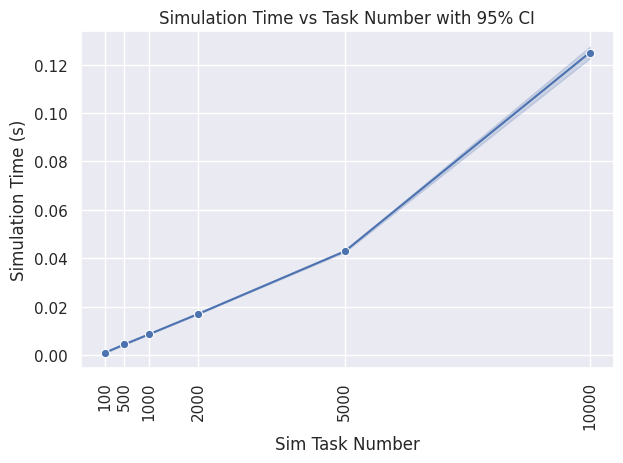

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df_time_task and contains 'sim_task_number' and 'sim_time'
plt.figure()
sns.lineplot(
    data=df_time_task,
    x="sim_task_number",
    y="sim_time",
    marker="o",
    errorbar="ci"  # default 95% bootstrap CI
)

plt.xlabel("Sim Task Number")
plt.ylabel("Simulation Time (s)")
plt.title("Simulation Time vs Task Number with 95% CI")
plt.xticks(sorted(df_time_task["sim_task_number"].unique()))
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

# Experiment 2: time-measure-device

sim_task_number: fixed at 1000
y_axis: Execution time
x_axis: sim_device_number

In [9]:
df_device_task = df[df["name"] == "time-measure-device"].copy()
df_device_task["sim_time"] = df_device_task["full_output"].apply(extract_sim_time)
df_device_task = df_device_task[["sim_device_number", "sim_time"]]

print(df_device_task.head())


    sim_device_number  sim_time
60                 10  0.000408
61                 10  0.000410
62                 10  0.000413
63                 10  0.000417
64                 10  0.000407


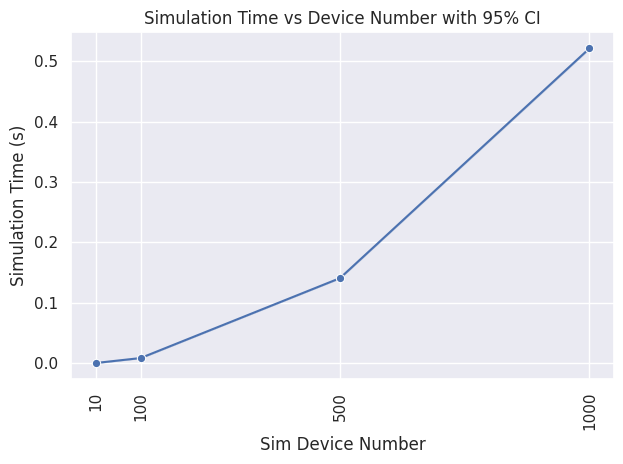

In [11]:
plt.figure()
sns.lineplot(
    data=df_device_task,
    x="sim_device_number",
    y="sim_time",
    marker="o",
    errorbar="ci"  # default 95% bootstrap CI
)

plt.xlabel("Sim Device Number")
plt.ylabel("Simulation Time (s)")
plt.title("Simulation Time vs Device Number with 95% CI")
plt.xticks(sorted(df_device_task["sim_device_number"].unique()))
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

# Experiment 3

x-axsis: sim_devation
y-axis: distance (float)

one line per sim_rr

In [17]:
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Extraction
def extract_distance(text):
    matches = re.findall(
        r"Distance\s*:\s*([-+]?(?:\d*\.\d+|\d+)(?:[eE][-+]?\d+)?)",
        str(text)
    )
    return float(matches[-1]) if matches else np.nan

# 2) Build df_dist
df_dist = df[df["name"] == "dist-measure"].copy()
df_dist["distance"] = df_dist["full_output"].apply(extract_distance)
df_dist = df_dist[["sim_deviation", "sim_rr", "distance"]]

print(df_dist.head())


     sim_deviation  sim_rr      distance
100            0.0       2  1.919350e-16
101            0.0       2  2.065050e-16
102            0.0       2  1.925630e-16
103            0.0       2  2.109800e-16
104            0.0       2  2.213270e-16


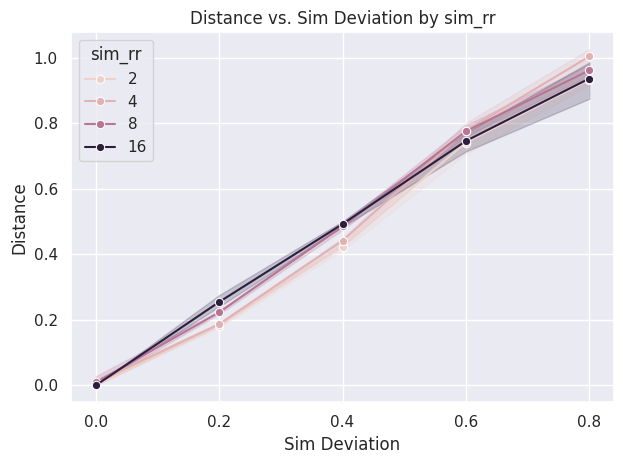

In [22]:
plt.figure()
sns.lineplot(
    data=df_dist,
    x="sim_deviation",
    y="distance",
    hue="sim_rr",
    markers=True,
    marker="o",
    dashes=True,
    errorbar="ci"
)
plt.xlabel("Sim Deviation")
plt.ylabel("Distance")
plt.title("Distance vs. Sim Deviation by sim_rr")
plt.xticks(sorted(df_dist["sim_deviation"].unique()))
plt.grid(True)
plt.tight_layout()
plt.show()